In [ ]:
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display as dp
from helper import *
import joblib
from wordcloud import WordCloud
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import phik
import time
!uv pip install scipy==1.12.0  #lower version required by gensim
from gensim.models import Word2Vec

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
nltk.download("vader_lexicon")
sns.set_style("darkgrid")
sns.set_palette("Set1")

#### 📖 EDA Table of Contents
[__Load Data__](#load-data)

[__EDA__](#eda)
- [1. Label (class) and Feature Distribution](#1-label-class-and-feature-distribution)
    - [1.1 Label Distribution](#11-label-distribution)
- [2. Feature Distribution](#2-feature-distribution)
    - [2.1 Subject Distribution](#21-subject-distribution)
    - [2.2 News Time Series Distribution](#22-news-time-series-distribution)
    - [2.3 News token Length Distribution](#23-news-token-lengths-distribution)
    - [2.4 Word Frequency](#24-word-frequency)

- [3. Sentiment Analysis](#3-sentiment-analysis)
    - [3.1 Uppercase Tokens and Sentimental Punctuations](#31-uppercase-tokens-and-sentimental-punctuations)
    - [3.2 Sentiment Polarity Analysis](#32-sentiment-polarity-analysis)
- [4. Correlation among Features and Label](#4-correlation-among-features-and-label)
- [5. Text Vectorization and Embedding Methods](#5-text-vectorization-and-embedding-methods)
    - [5.1 Word Frequency vectorization with TF-IDF Vectorizer](#51-word-frequency-vectorization-with-tf-idf-vectorizer)
    - [5.2 Context Embedding with Word2Vec](#52-context-embedding-with-word2vec)


### Load Data

In [ ]:
df_org = joblib.load("data/eda_df_df.pkl")
df = df_org.copy()
df.rename(columns={"label": "label_encode"}, inplace=True)
df["label"] = df.label_encode.apply(lambda i: "real" if i == 0 else "fake")
df = df.sort_values("label")

- `label 0`: real new
- `label 1`: fake news

In [134]:
print("sample sequences:")
dp(df.sample(10, random_state=2).sequence.tolist())
print("labels:")
dp(df.sample(10, random_state=2).label_encode.tolist())

sample sequences:


['london police give all clear, lift cordon in financial district London police said they had lifted a cordon put in place in part of the city s financial district on Wednesday morning after determining that an item found there was not suspicious.  Earlier, officers had sealed off an area in Moorgate and Liverpool Street after a report of a suspicious package.   We re all clear at Moorgate. Thank you for your patience cordons have been lifted,  City of London police posted on Twitter.',
 'newt gingrich puts the weirdest spin on trump’s incessant, shallow tweeting Trump has a serious lack of impulse control, particularly on social media. We ve known this forever, and it s to the point where some have begun calling for the media to return to real journalism and stop focusing on his damn tweets. Part of the reason so many feel we can t ignore them is because they represent a lack of control, and because they re the inner thoughts of a madman who thinks he s still a private citizen and can

labels:


[0, 1, 0, 0, 1, 1, 1, 0, 0, 1]

> From above samples of fake and real news, we don't see obvious spoiler patterns \
after data cleaning.

### EDA
EDA is conducted only on training data set. 

During the analysis, we generate potential features that could be beneficial for \
modeling.

### 1. Label and Feature Distribution

#### 1.1 Label Distribution

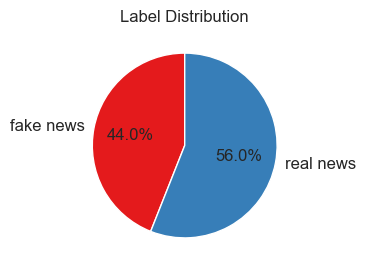

In [17]:
fig_size(4, 3)
plt.pie(
    [df.label.value_counts()["fake"], len(df) - df.label.value_counts()["fake"]],
    labels=["fake news", "real news"],
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 12},
)

plt.title("Label Distribution")
plt.show()

__Label Distribution__

> Label distribution is imbalanced, we need to balance the dataset for modeling.

### 2. Feature Distribution

#### 2.1 Subject Distribution

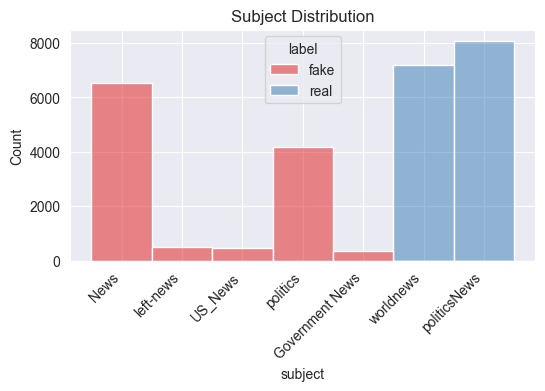

In [18]:
fig_size(6, 3)

sns.histplot(data=df, x="subject", hue="label")

plt.xticks(rotation=45, ha="right")
plt.title("Subject Distribution")
plt.show()

__Subject Distribution__:

Fake and real news are distributed in different subjects with no overlap.

> We won't use `subject` as a feature for modeling to prevent data leakage.

#### 2.2 News Time Series Distribution

- what is the time span of fake news and real news?
- how are fake news and real news distributed in different time periods?

In [19]:
df["day_of_week"] = df["date"].dt.day_of_week
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year.astype(int)

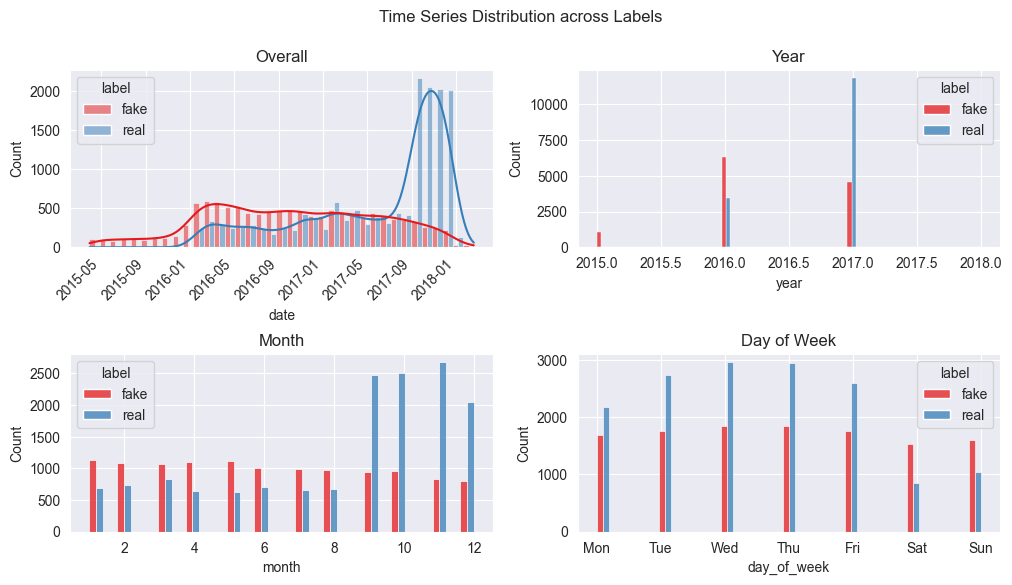

In [20]:
fig_size(12, 6)

plt.subplot(2, 2, 1)
sns.histplot(data=df, x="date", hue="label", multiple="dodge", kde=True)
plt.xticks(rotation=45, ha="right")
plt.title("Overall")

plt.subplot(2, 2, 2)
sns.histplot(data=df, x="year", hue="label", multiple="dodge")
plt.title("Year")
# plt.xticks([2015.0, 2015.5, 2016.0, 2016.5, 2017.0, 2017.5, 2018.0], '')
plt.subplot(2, 2, 3)
sns.histplot(data=df, x="month", hue="label", multiple="dodge")
plt.title("Month")

plt.subplot(2, 2, 4)
sns.histplot(data=df, x="day_of_week", hue="label", multiple="dodge")
plt.title("Day of Week")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.subplots_adjust(hspace=0.6)
plt.suptitle("Time Series Distribution across Labels")
plt.show()

__Time Series Distribution across Labels__:

Time series of fake news and real news are distributed in different time periods \
with different frequencies in this dataset. 

This is very likely due to the `uneven collection of data` in different periods \
of time and of different sources. (it's impossible to have no real news prior to \
2016!)

- Real news: there's no real news earlier than 2016, after 2019-09, the \
distribution of real news increased dramatically (> 2000 news per month).

- Fake news: the distribution of fake news has 2 distinctive segments, before \
and after 2016.

> This pattern is only specific to this dataset, thus it won't be used as a \
feature for modeling.

__Day of Week:__

Interestingly, there's far more fake news than real news on weekends ! \
My guessing is that the press/ news agencies that make real news are not working \
or working less on weekends thus less news are published.

> For different time related features, we'd only use `day of week` for modeling as \
it is least impacted by the uneven data collection throughout time and have shown \
an interesting pattern with the label. And we would convert it to `is_weekend`.


In [21]:
df["is_weekend"] = df.day_of_week.apply(lambda i: 1 if i in [5, 6] else 0)

#### 2.3 News Token Lengths Distribution

- Distribution of title, text, and sequence length

- What is an appropriate sequence length for truncation in transformer models?

- What models should be considered ?


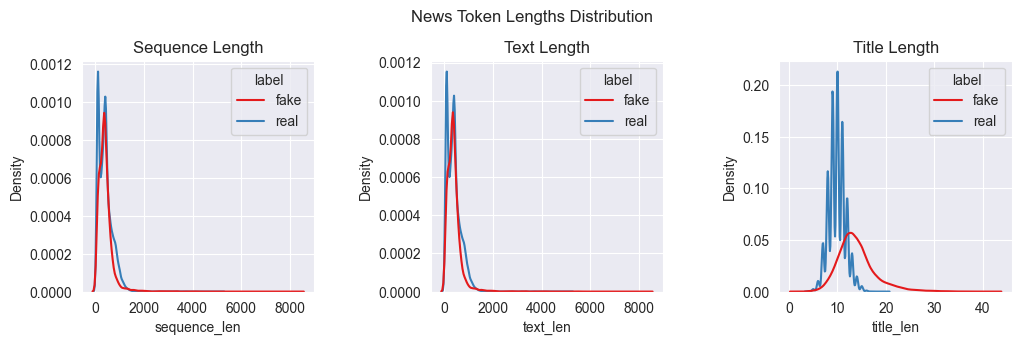

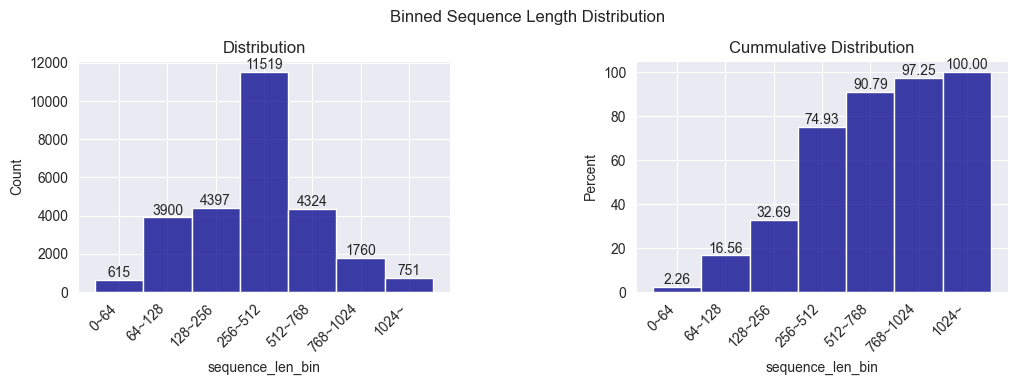

In [ ]:
df["sequence_len"] = df["sequence"].apply(lambda i: len(i.split(" ")))

fig_size(12, 3)

plt.subplot(1, 3, 1)
sns.kdeplot(data=df, x="sequence_len", hue="label")
plt.title("Sequence Length")


plt.subplot(1, 3, 2)
sns.kdeplot(data=df, x="text_len", hue="label")
plt.title("Text Length")

plt.subplot(1, 3, 3)
sns.kdeplot(data=df, x="title_len", hue="label")
plt.title("Title Length")
plt.suptitle("News Token Lengths Distribution", y=1.05)
# plt.suptitle("Sequence Length Distribution")
plt.subplots_adjust(wspace=0.5)

plt.show()


fig_size(12, 3)
plt.subplot(1, 2, 1)
seq_len_bin = pd.cut(
    df.sequence_len,
    [0, 64, 128, 256, 512, 768, 1024, 10000],
    labels=[
        "0~64",
        "64~128",
        "128~256",
        "256~512",
        "512~768",
        "768~1024",
        "1024~",
    ],
)
df["sequence_len_bin"] = seq_len_bin
ax = sns.histplot(
    data=df,
    x="sequence_len_bin",
    # hue="label",
    multiple="stack",
    color="darkblue",
)

mark_bar(ax, digit=0)
plt.xticks(rotation=45, ha="right")

plt.title("Distribution")

plt.subplot(1, 2, 2)
ax = sns.histplot(
    data=df,
    x="sequence_len_bin",
    # hue="label",
    cumulative=True,
    stat="percent",
    multiple="stack",
    color="darkblue",
)

mark_bar(ax, digit=2)
plt.xticks(rotation=45, ha="right")
plt.title("Cummulative Distribution")

plt.suptitle("Binned Sequence Length Distribution", y=1.05)
plt.subplots_adjust(wspace=0.5)

plt.show()

__News Token Lengths Distribution__

The distributions of news sequence and text lengths are similar across labels, \
but the title length distributions differ significantly, with fake news having \
longer titles.

> Title length is a strong candidate feature for modeling.

From the cumulative distribution of sequence lengths, over 25% of news sequences \
exceed 512 words, which is the typical maximum sequence length for transformer \
models like those in the BERT family.

Additionally, 97.5% of news sequences are shorter than 1024 words, making this \
length an ideal truncation point to retain as much information as possible. \
However, longer sequences can significantly slow down model training.

> Consider exploring models capable of handling longer sequences, such as Longformer.

> Since shorter sequence lengths are more computationally efficient, experimenting \
with lengths like 512 words and evaluate the trade-off between accuracy \
and training time.

__Is there any association between sequence length and news subject?__

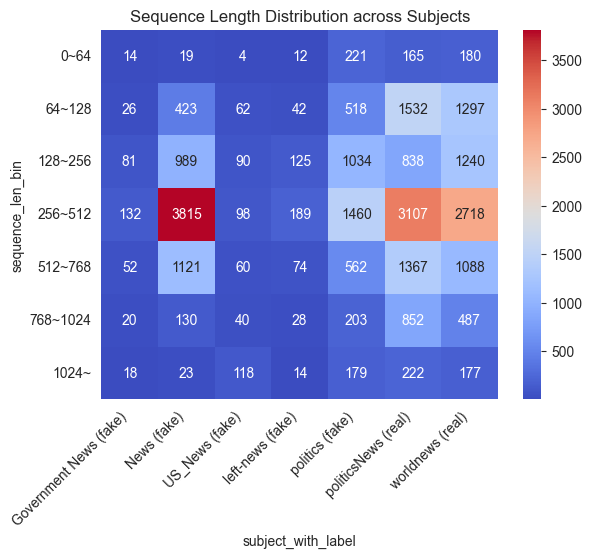

In [ ]:
df["subject_with_label"] = df.apply(lambda i: f"{i['subject']} ({i['label']})", axis=1)

sns.heatmap(
    pd.crosstab(df.subject_with_label, df.sequence_len_bin).T,
    annot=True,
    fmt="d",
    cmap="coolwarm",
)

plt.xticks(rotation=45, ha="right")
plt.title("Sequence Length Distribution across Subjects")
plt.show()

There is no evident association between news subjects and sequence length. \
Across all subjects, the majority of news sequences range from 128 to 768 words, \
with a distribution across labels consistent with the patterns observed earlier.

#### 2.4 Word Frequency

- Word cloud
- word frequency
- Does the word frequency differ between fake news and real news?

In [ ]:
words_fake = " ".join(
    df.loc[df.label_encode == 1].sequence.sample(5000, random_state=1).tolist()
)
wordcloud_fake = WordCloud(
    max_font_size=40,
    stopwords=stopwords,
    min_word_length=2,
    max_words=50,
).generate(words_fake)

words_real = " ".join(
    df.loc[df.label_encode == 0].sequence.sample(5000, random_state=1).tolist()
)
wordcloud_real = WordCloud(
    max_font_size=40,
    stopwords=stopwords,
    min_word_length=2,
    max_words=50,
).generate(words_real)

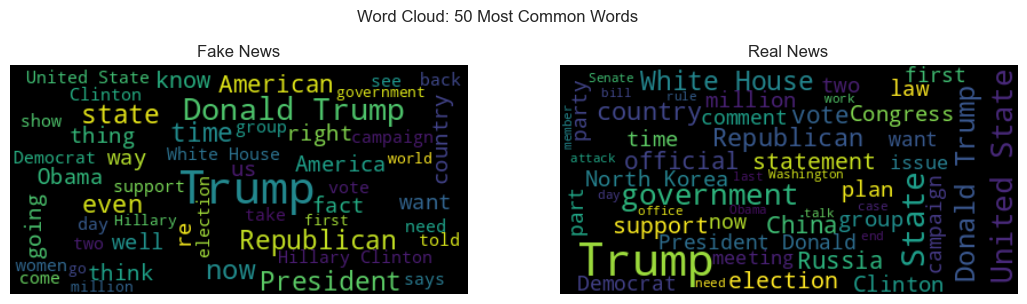

In [199]:
fig_size(13, 3.5)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.axis("off")
plt.title("Real News")
plt.suptitle("Word Cloud: 50 Most Common Words")
plt.show()

__Frequency of most common words in fake and real news__

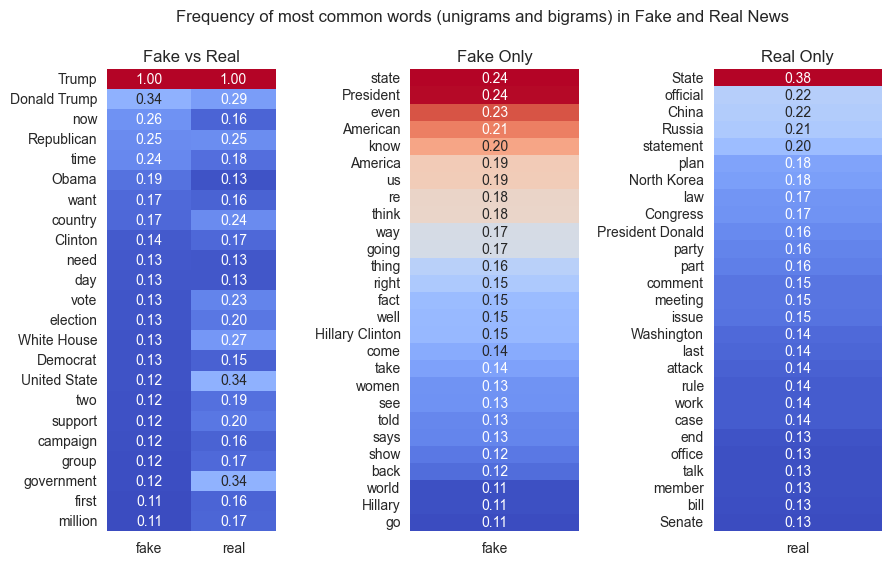

In [200]:
fake_words_freq = pd.DataFrame([wordcloud_fake.words_]).T
real_words_freq = pd.DataFrame([wordcloud_real.words_]).T
words_freq = pd.concat([fake_words_freq, real_words_freq], axis=1)
words_freq.columns = ["fake", "real"]

real_only = words_freq.loc[words_freq.fake.isna()].drop(columns=["fake"])
fake_only = words_freq.loc[words_freq.real.isna()].drop(columns=["real"])

words_freq = words_freq.dropna()
fig_size(10, 6)
plt.subplot(1, 3, 1)
sns.heatmap(words_freq, annot=True, fmt=".2f", cbar=False, cmap="coolwarm")
plt.title("Fake vs Real")
plt.subplot(1, 3, 2)
sns.heatmap(fake_only, annot=True, fmt=".2f", cbar=False, cmap="coolwarm")
plt.title("Fake Only")
plt.subplot(1, 3, 3)
sns.heatmap(real_only, annot=True, fmt=".2f", cbar=False, cmap="coolwarm")
plt.title("Real Only")

plt.suptitle(
    "Frequency of most common words (unigrams and bigrams) in Fake and Real News"
)
plt.subplots_adjust(wspace=0.8)
plt.show()

💡 First, looking at the frequent words, we don't see obvious spolilers, this meant \
that after cleaning, the data is quite clean !

Both fake news and real news are mostly about politics, and for both groups, \
`Donald Trump`, `Trump` is the most common word.

In fake news only common words, we can see more names of american politicians such as 
- `Obama`,
- `Hilary Clinton`, 
- `Hilary`. 
And also more US related words such as 
- `America`,
- `American`.

While in real news, we see more location related words such as:
- `China`,
- `Russia`,
- `North Korea`,
- `Washington`

The difference come from the different subject of the news, there's more \
international news in real news, and more local US politics news in fake news.

> Frequency of words can also be a good feature, we can use `TFIDVectorizer`


### 3. Sentiment Analysis

#### 3.1 Uppercase Tokens and Sentimental Punctuations

Heavier usage of uppercase tokens and sentimental punctuations such as question \
marks and exclamation marks are used to convey stronger sentiment.

Here we compare the percentage of `uppercase tokens` and `sentimental` \
`punctuations` (question marks and exclamation marks) across fake news and \
real news.

##### 3.1.1 Detect Uppercase Tokens Frequency

Here we use different thresholds to detect uppercase tokens in text from 5% to 50%. 

- Would we observe different patterns in fake news and real news across thresholds?

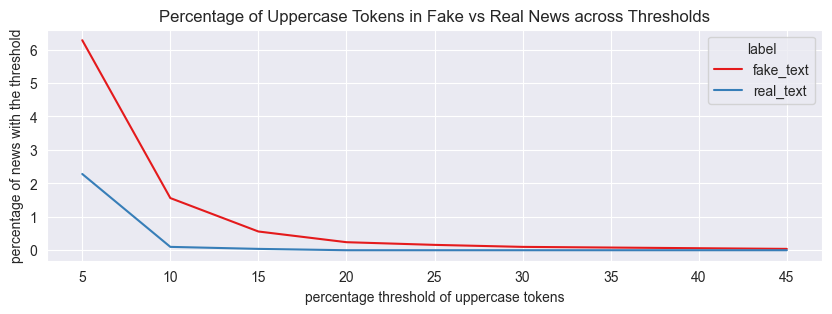

In [ ]:
fake_text_cap_dict = {}
real_text_cap_dict = {}


for cap_threshold in np.arange(5, 50, 5):
    words_fake_text_cap_percentage = (
        df.loc[df.label_encode == 1]
        .text.sample(5000, random_state=1)
        .apply(lambda i: detect_all_caps(i, threshold=cap_threshold))
        .mean()
        * 100
    )
    words_real_text_cap_percentage = (
        df.loc[df.label_encode == 0]
        .text.sample(5000, random_state=1)
        .apply(lambda i: detect_all_caps(i, threshold=cap_threshold))
        .mean()
        * 100
    )

    fake_text_cap_dict[cap_threshold] = words_fake_text_cap_percentage
    real_text_cap_dict[cap_threshold] = words_real_text_cap_percentage

cap_percentage_df = pd.DataFrame(
    [fake_text_cap_dict, real_text_cap_dict],
    index=["fake_text", "real_text"],
).T.reset_index(inplace=True)

cap_percentage_df = cap_percentage_df.melt(
    id_vars=["index"], var_name="label", value_name="percentage"
)

fig_size(10, 3)
sns.lineplot(data=cap_percentage_df, x="index", y="percentage", hue="label")
plt.xlabel("percentage threshold of uppercase tokens")
plt.ylabel("percentage of news with the threshold")
plt.title("Percentage of Uppercase Tokens in Fake vs Real News across Thresholds")
plt.xticks(np.arange(5, 50, 5))
plt.show()

__Uppercase Tokens Frequency of Fake vs Real News across Thresholds__

The proportion of uppercase tokens is higher in fake news compared to real news.

The difference is most notable at a 5% threshold, where fake news \
has approximately 6% uppercase tokens, while real news has around 2%. Although the \
absolute percentages are smaller overall, the difference remains evident.

> We would use `text_5_percent_upper` as feature.

In [10]:
df["text_5_percent_upper"] = df.text.apply(
    lambda i: detect_all_caps(i, threshold=5)
).astype(int)

##### 3.1.2 Detect Question Marks and Exclamation Marks


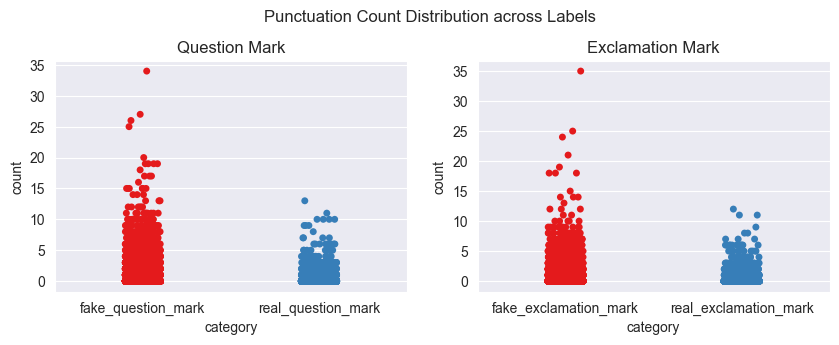

In [ ]:
fake_question_mark_stats = (
    df.query("label_encode == 1").text.apply(lambda i: list(i).count("?"))
)

fake_exclamation_mark_stats = (
    df.query("label_encode == 1").text.apply(lambda i: list(i).count("!"))
)

real_question_mark_stats = df.query("label_encode == 0").text.apply(
    lambda i: list(i).count("?")
)

real_exclamation_mark_stats = df.query("label_encode == 0").text.apply(
    lambda i: list(i).count("!")
)

punctuation_df = pd.DataFrame(
    {
        "fake_question_mark": fake_question_mark_stats,
        "fake_exclamation_mark": fake_exclamation_mark_stats,
        "real_question_mark": real_question_mark_stats,
        "real_exclamation_mark": real_exclamation_mark_stats,
    }
)

punctuation_df = pd.melt(
    punctuation_df,
    value_vars=[
        "fake_question_mark",
        "real_question_mark",
        "fake_exclamation_mark",
        "real_exclamation_mark",
    ],
)

fig_size(10, 3)
plt.subplot(1, 2, 1)
sns.stripplot(
    data=punctuation_df.query('variable.str.contains("question")'),
    x="variable",
    y="value",
    hue="variable",
)
plt.xlabel("category")
plt.ylabel("count")
plt.title("Question Mark")

plt.subplot(1, 2, 2)
sns.stripplot(
    data=punctuation_df.query('~variable.str.contains("question")'),
    x="variable",
    y="value",
    hue="variable",
)

plt.xlabel("category")
plt.ylabel("count")
plt.title("Exclamation Mark")

plt.suptitle("Punctuation Count Distribution across Labels", y=1.05)

plt.show()

__Uppercase Tokens and Sentimental Punctuations__

Fake news features a higher frequency of uppercase tokens and sentimental \
punctuations than real news, suggesting a more intense emotional tone. 

> `question_mark_count` and `exclamation_mark_count` would be used as \
feartures.

In [ ]:
df["question_mark_count"] = df.text.apply(lambda i: list(i).count("?"))
df["exclamation_mark_count"] = df.text.apply(lambda i: list(i).count("!"))

#### 3.2 Sentiment Polarity Analysis

Use `SentimentIntensityAnalyzer` from `nltk` to detect sentiment scores. 

This analyzer uses lexicons from [Vader](https://github.com/cjhutto/vaderSentiment). \
The score ranges from -1 to 1, where -1 is negative sentiment, 0 is neutral, \
and 1 is positive sentiment.

There are 4 sentiment scores:
- `neg`: negative sentiment
- `neu`: neutral sentiment
- `pos`: positive sentiment
- `compound`: compound sentiment (weighted average of the other scores)


In [ ]:
senti = SentimentIntensityAnalyzer()
fake_news_sentiment_scores = (
    df.query("label_encode == 1").text.apply(lambda i: senti.polarity_scores(i)).tolist()
)

fake_senti_compound = [i["compound"] for i in fake_news_sentiment_scores]
fake_senti_neg = [i["neg"] for i in fake_news_sentiment_scores]
fake_senti_neu = [i["neu"] for i in fake_news_sentiment_scores]
fake_senti_pos = [i["pos"] for i in fake_news_sentiment_scores]

real_news_sentiment_scores = (
    df.query("label_encode == 0").text.apply(lambda i: senti.polarity_scores(i)).tolist()
)

real_senti_compound = [i["compound"] for i in real_news_sentiment_scores]
real_senti_neg = [i["neg"] for i in real_news_sentiment_scores]
real_senti_neu = [i["neu"] for i in real_news_sentiment_scores]
real_senti_pos = [i["pos"] for i in real_news_sentiment_scores]

fake_senti_df = pd.DataFrame(
    {
        "fake_news_sentiment_scores_compound": fake_senti_compound,
        "fake_news_sentiment_scores_neg": fake_senti_neg,
        "fake_news_sentiment_scores_neu": fake_senti_neu,
        "fake_news_sentiment_scores_pos": fake_senti_pos,
    }
)

real_senti_df = pd.DataFrame(
    {
        "real_news_sentiment_scores_compound": real_senti_compound,
        "real_news_sentiment_scores_neg": real_senti_neg,
        "real_news_sentiment_scores_neu": real_senti_neu,
        "real_news_sentiment_scores_pos": real_senti_pos,
    }
)

sentiment_df = pd.concat([fake_senti_df, real_senti_df], axis=1)

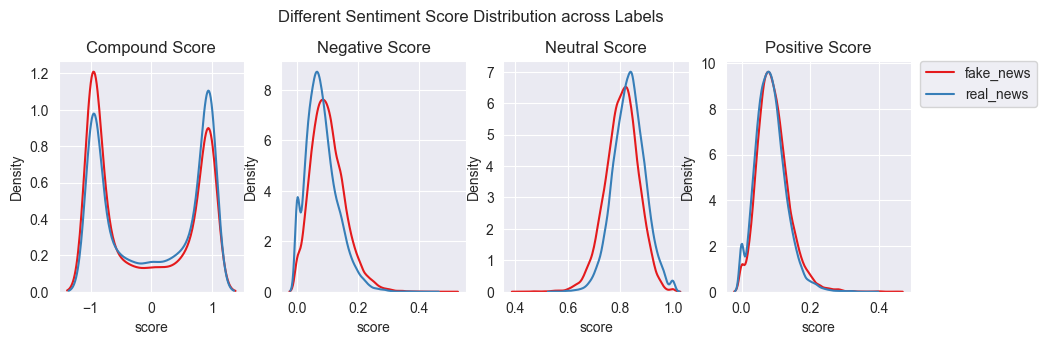

In [208]:
fig_size(11, 3)
plt.subplot(1, 4, 1)
sns.kdeplot(
    sentiment_df.fake_news_sentiment_scores_compound,
    label="fake_news",
)
sns.kdeplot(
    sentiment_df.real_news_sentiment_scores_compound,
    label="real_news",
)
plt.xlabel("score")
plt.title("Compound Score")

plt.subplot(1, 4, 2)
sns.kdeplot(
    sentiment_df.fake_news_sentiment_scores_neg,
    label="fake_news",
)
sns.kdeplot(
    sentiment_df.real_news_sentiment_scores_neg,
    label="real_news",
)
plt.xlabel("score")
plt.title("Negative Score")

plt.subplot(1, 4, 3)
sns.kdeplot(
    sentiment_df.fake_news_sentiment_scores_neu,
    label="fake_news",
)
sns.kdeplot(
    sentiment_df.real_news_sentiment_scores_neu,
    label="real_news",
)
plt.xlabel("score")
plt.title("Neutral Score")

plt.subplot(1, 4, 4)
sns.kdeplot(
    sentiment_df.fake_news_sentiment_scores_pos,
    label="fake_news",
)
sns.kdeplot(
    sentiment_df.real_news_sentiment_scores_pos,
    label="real_news",
)
plt.xlabel("score")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Positive Score")
plt.suptitle("Different Sentiment Score Distribution across Labels", y=1.05)
plt.subplots_adjust(hspace=0.6)
plt.show()

__Sentiment Polarity Analysis__

Based on the above distribution, fake news tends to have higher negative sentiment \
scores compared to real news, while real news generally scores higher on neutrality. \
Both exhibit similar levels of positive sentiment.

> Fake news demonstrates a stronger negative sentiment than real news. Sentiment \
scores would be used as features.

In [ ]:
senti = SentimentIntensityAnalyzer()
sentiment_scores_ls = df.text.apply(lambda i: senti.polarity_scores(i)).tolist()

senti_compound = [i["compound"] for i in sentiment_scores_ls]
senti_neg = [i["neg"] for i in sentiment_scores_ls]
senti_neu = [i["neu"] for i in sentiment_scores_ls]
senti_pos = [i["pos"] for i in sentiment_scores_ls]

df["senti_compound"] = senti_compound
df["senti_neg"] = senti_neg
df["senti_neu"] = senti_neu
df["senti_pos"] = senti_pos

### 4. Correlation among Features and Label

- Use Phik to detect linear correlation among features and label

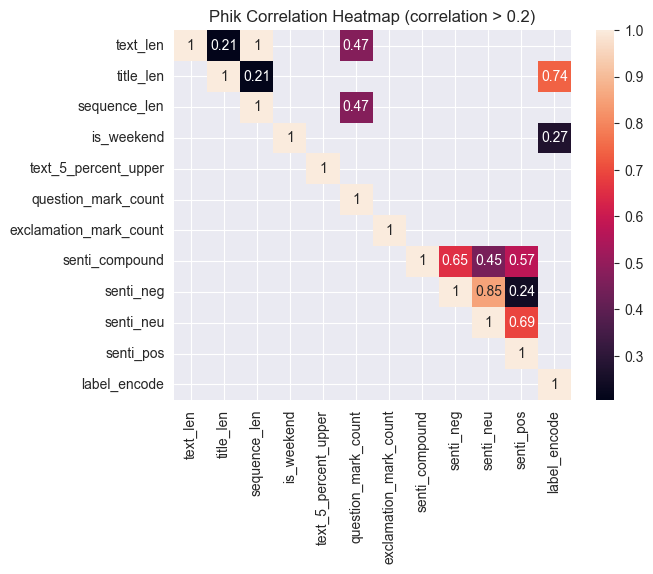

In [246]:
num_cols = [
    "text_len",
    "title_len",
    "sequence_len",
    "is_weekend",
    "text_5_percent_upper",
    "question_mark_count",
    "exclamation_mark_count",
    "senti_compound",
    "senti_neg",
    "senti_neu",
    "senti_pos",
    "label_encode",
]

corr = df[num_cols].phik_matrix(interval_cols=num_cols)
tri_mask = np.triu(np.ones_like(corr, dtype=bool))
filter_mask = np.array(corr > 0.2)
comb_mask = filter_mask & tri_mask

sns.heatmap(corr, annot=True, mask=~comb_mask)
plt.title("Phik Correlation Heatmap (correlation > 0.2)")
plt.show()

__Phik Correlation__

`Label` is strongly correlated `title_length` and `title_15_percent_upper`. \
In previous analysis we observed association between text length and \
label, but the relationship is not linear.

senti_neu is strongly correlated with senti_neg. We would drop senti_neu \
to avoid multicollinearity.


In [ ]:
df.drop(columns = ['senti_neu'], inplace=True)
joblib.dump(df, "data/heuristic_feats_df.pkl")

### 5. Text Vectorization and Embedding Methods

Text vectorization and content embedding are both widely used methods for \
converting text into vectors. We will evaluate which approach generates more \
predictive features.

#### 5.1 Word Frequency vectorization with TF-IDF Vectorizer

Before the rise of deep learning for text classification, the most common \
technique for text classification was TF-IDF in combination with Logistic \
Regression/ SVM/ Naive Bayes.

Here, `TfidfVectorizer` is used to create static word frequency features. \
And followed by a simple Logistic Regression model to evaluate the predictive \
power of the word frequency features.

In order to only focus on the semantic meaning of words, we clean the news \
sequences by `removing punctuation` and converting all words to `lowercase` \
prior to embedding.

In [ ]:
data = joblib.load("data/model_dataset_dict.pkl")
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]

fitted_tfidf_grid = tfidf_grid.fit(X_train, y_train)
tfidf_model = fitted_tfidf_grid.best_estimator_

start_time = time.time()

tfidf_model.fit(X_train, y_train)

end_time = time.time()
print(f"Model training time: {sec_to_min_sec(end_time - start_time)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Model training time: 00 Minutes 45 Seconds


> It only takes 45 seconds to train the Tfidf model pipeline.

,Feats,Accuracy,Recall
score,TF-IDF,0.979,0.972


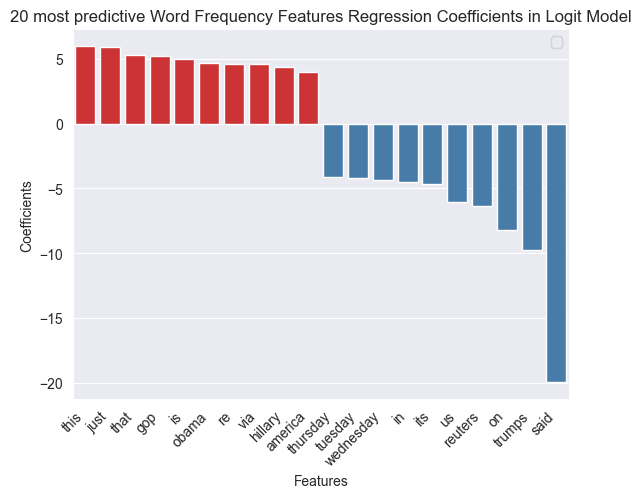

In [ ]:
val_pred = tfidf_model.predict(X_val)

acc = accuracy_score(y_val, val_pred)
recall = recall_score(y_val, val_pred)

tfidf_res_df = pd.DataFrame(
    {
        "Feats": "TF-IDF",
        "Accuracy": [acc],
        "Recall": [recall],
    },
    index=["score"],
).round(3)

dp(tfidf_res_df)

tfid_feat_names = tfidf_model[1].get_feature_names_out().tolist()

tfid_logit_coef = tfidf_model[-1].coef_[0]
tfid_logit_coef = pd.DataFrame(
    {"Features": tfid_feat_names, "Coefficients": tfid_logit_coef}
).sort_values("Coefficients", ascending=False)

pos_coef = tfid_logit_coef.head(10).copy()
pos_coef["tendency"] = "positive"
neg_coef = tfid_logit_coef.tail(10).copy()
neg_coef["tendency"] = "negative"


tfid_most_predictive_20 = pd.concat([pos_coef, neg_coef])

sns.barplot(
    x=tfid_most_predictive_20.Features,
    y=tfid_most_predictive_20.Coefficients,
    hue=tfid_most_predictive_20.tendency,
)

plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.title(
    "20 most predictive Word Frequency Features Regression Coefficients in Logit Model"
)
plt.legend([])
plt.show()

__TF-IDF + Logistic Regression__

Word frequency features alone is very predictive. And it is also very efficient \
to train the model (45 seconds).

Looking at the most predictive features (10 positive and 10 negative), \
in positive words, except from the short words,

- gop
- obama
- hillary
- america 

have the most positive coefficients, while in negative words, 

- said
- trumps
- reuters
- tuesday ~ thursday

have the most negative coefficients.

Of all the features, surprisingly,`said` has the highest absolute coefficient. \
This is because in real news, the source of a sentence is often referenced by \
`XYZ said`. 

Also, weekdays have high absolute coefficients, this is also a common wording \
pattern in real news.

> Seeing that TF-IDF is able to capture word frequency, are we able to get even \
better results by using word embeddings which captures semantic meaning of \
sentences?

#### 5.2 Context Embedding with Word2Vec

Use Word2Vec to create static context embedding features. 

Same as above, the sequences are cleaned by `removing punctuation` and \
converted to `lowercase` prior to embedding.

__Word2Vec params:__ 

- vector size: 100
- window size: 12
- word min_count: 10


Clean training and validation data sequences

In [ ]:
seq_ls = df.sequence.apply(lambda i: i.split(" ")).tolist()
cleaned_seq_ls = clean_seq_ls(seq_ls)

val_seq_ls = X_val.sequence.apply(lambda i: i.split(" ")).tolist()
cleaned_val_seq_ls = clean_seq_ls(val_seq_ls)

__Clean training data sequences and train Word2Vec model__

In [ ]:
w2v_cleaned_model = Word2Vec(
    cleaned_seq_ls, vector_size=100, window=12, min_count=10, workers=4, seed=0
)

print(f"Vector embedding shape: {w2v_cleaned_model.wv.vectors.shape}")

Vector embedding shape: (26580, 100)


> We have approximately 27k case insensitive unique words in our embedding.

__Some examples of words with similar embeddings (with cosine similarity score):__

In [307]:
print("trump:")
print(w2v_cleaned_model.wv.most_similar("trump", topn=5), end="\n\n")
print("america:")
print(w2v_cleaned_model.wv.most_similar("america", topn=5), end="\n\n")
print("official:")
print(w2v_cleaned_model.wv.most_similar("official", topn=5), end="\n\n")

trump:
[('trumps', 0.7728738784790039), ('presidentelect', 0.608302891254425), ('trumpthe', 0.5868316888809204), ('trump’s', 0.5803015232086182), ('obama', 0.5239793062210083)]

america:
[('nation', 0.6465035676956177), ('americas', 0.6334277987480164), ('planet', 0.5881608128547668), ('american', 0.5752047300338745), ('globalization', 0.5708626508712769)]

official:
[('source', 0.7319043874740601), ('diplomat', 0.6811341047286987), ('officials', 0.6494786739349365), ('sources', 0.5991377234458923), ('aide', 0.571700930595398)]



> From above examples, we can see that the embedding is able to capture the semantic \
meaning of words.

News sequences vary in length, so to ensure each sequence has a consistent \
embedding feature, here we calculate the `average` of the word embeddings \
present in each sequence, in our case, `each sequence would have a` \
`100-dimensional embedding`.

__Calculate average embedding for training and validation data sequence__

In [ ]:
cleaned_seq_embed_avg_arr = get_embed_avg_arr(cleaned_seq_ls, w2v_cleaned_model)
cleaned_val_seq_embed_avg_arr = get_embed_avg_arr(cleaned_val_seq_ls, w2v_cleaned_model)

print("Shape of train sequence embeddings: ", cleaned_seq_embed_avg_arr.shape)
print("Shape of val sequence embeddings: ", cleaned_val_seq_embed_avg_arr.shape)

Shape of train sequence embeddings:  (27266, 100)
Shape of val sequence embeddings:  (4812, 100)


__Verify the predictive power of averaged embedding features__

Take a quick look at how predictive the embedding features are.

,Accuracy,Recall
scores,0.959,0.948


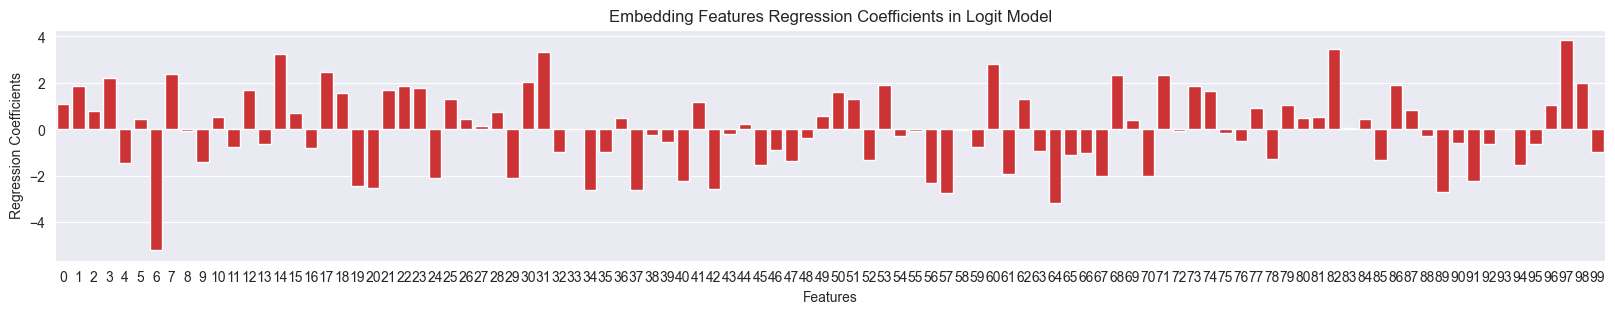

In [126]:
embed_x_train = cleaned_seq_embed_avg_arr
embed_x_val = cleaned_val_seq_embed_avg_arr
embed_y_train = df.label_encode
embed_y_val = y_val

embed_model = quick_logreg(
    X_train=embed_x_train,
    y_train=embed_y_train,
    X_test=embed_x_val,
    y_test=embed_y_val,
)

fig_size(20, 3)
sns.barplot(x=range(embed_x_train.shape[1]), y=embed_model.coef_[0])
plt.title("Embedding Features Regression Coefficients in Logit Model")
plt.xlabel("Features")
plt.ylabel("Regression Coefficients")
plt.show()

__Embedding Features:__

The averaged embedding features are highly predictive. It is intriguing that \
averaging the embeddings of all words in a sentence can still capture contextual \
meaning.

However, it is surprising that their predictive performance is slightly lower \
than that of TF-IDF features (accuracy: 0.96 vs. 0.98).

### 6. Conclusion

In this notebook, we've performed exploratory data analysis on the dataset and \
developed a few candidate features that might be useful for modeling.

__Observations__

- Label distribution is imbalanced (44% fake news, 56% real news).
- Fake and real news are distributed in different subjects with no overlap.
- Fake and real news are distributed in different time periods with different \
frequencies.
- There's more fake news than real news on weekends, and vice versa.
- The title length distribution of fake news is longer than real news.
- Fake news have higher negative sentiment scores compared to real news
- Fake news have higher punctuation counts compared to real news
- Fake news have more uppercase tokens compared to real news
- Both approaches for converting text into vectors, TF-IDF and Word2Vec, have \
produced highly predictive features with accuracy > 95%.


💡 This is the end of the notebook, continue to `3_modeling.ipynb`